In [1]:
import pandas as pd

C:\Users\Alexandra\AppData\Local\Temp\ipykernel_13412\4080736814.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## A/A-тесты
* A/A-тест помогает удостовериться в том, что разделение выборок происходит корректно
* Позволяет определить уровень значимости для A/B-теста
* В целом проверяет надёжность работы системы тестов

Нулевая и альтернативная гипотезы берутся такие же как для A/B теста. У нас нет настоящего датасета, подготовленного для A/A и A/B тестирования, поэтому для примера возьмём контрольную группу из датасета cookie cats с прошлой лекции вместо настоящих исторических данных

In [4]:
data = pd.read_csv("../data/cookie_cats.csv")
data = data[data['version'] == 'gate_30'].drop(columns=['version']).reset_index(drop=True)
data = data[data.sum_gamerounds < data.sum_gamerounds.max()]
data

,userid,sum_gamerounds,retention_1,retention_7
0,116,3,False,False
1,337,38,True,False
2,1066,0,False,False
3,2101,0,False,False
4,2179,39,True,False
...,...,...,...,...
44695,9998576,14,True,False
44696,9998623,7,False,False
44697,9999178,21,True,False
44698,9999349,10,False,False


Разобьём пользователей на группы, как сделали бы, готовя проведение A/B-тестирования

In [5]:
a1 = data.sample(frac = 0.55)
a2 = data.drop(a1.index)

len(a1), len(a2)

(24584, 20115)

Если у нас есть представления о том, какое разбиение хотелось получить, и неизвестно, какое получено в реальности, можно выполнить проверку на SRM — Sample Rate Mismatch, отклонение фактического разбиения от ожидаемого. Здесь приведён [$\chi^2$-критерий](https://ru.wikipedia.org/wiki/%D0%9A%D1%80%D0%B8%D1%82%D0%B5%D1%80%D0%B8%D0%B9_%D1%85%D0%B8-%D0%BA%D0%B2%D0%B0%D0%B4%D1%80%D0%B0%D1%82). Если p-value *достаточно близко к 1*, разбиение не соответствует ожидаемому и нужно его переделать, чтобы правильно провести эксперимент.

In [6]:
from scipy.stats import chisquare

chisquare([len(a1), len(a2)], f_exp = [24600, 20099])

Power_divergenceResult(statistic=0.02314345615220917, pvalue=0.8790846123238008)

Бутстрап: делаем множество разбиений и для каждого проводим t-test

In [8]:
from scipy.stats import ttest_ind
from tqdm import tqdm

p_values = []

for a in tqdm(range(10000)):
    a1 = data.sample(frac = 0.55)
    a2 = data.drop(a1.index)
    test = ttest_ind(a1['sum_gamerounds'], a2['sum_gamerounds'], equal_var=False)
    p_values.append(test.pvalue)

Text(0.5, 0, 'P-value')

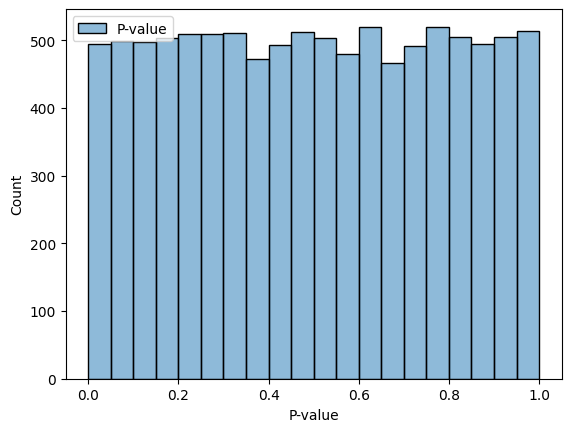

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(data=pd.DataFrame(p_values, columns=['P-value']), bins=20)
plt.xlabel("P-value")

Для заключения об успехе A/A теста полученное распределение полученных p-значений должно быть равномерным. Для проверки равномерности используем критерий Колмогорова-Смирнова

In [16]:
from scipy.stats import kstest

ks = kstest(p_values,"uniform")
ks

KstestResult(statistic=0.005323511460793129, pvalue=0.9379632072811752, statistic_location=0.7183235114607931, statistic_sign=-1)

In [26]:
ks.pvalue > 0.05

True

In [27]:
for i in tqdm(range(1000)):
    a1 = data.sample(frac = 0.55)
    a2 = data.drop(a1.index)
    test = ttest_ind(a1['sum_gamerounds'], a2['sum_gamerounds'], equal_var=False)
    if (test.pvalue < 0.05):
        break

  2%|▏         | 20/1000 [00:01<01:17, 12.61it/s]


In [28]:
test

TtestResult(statistic=2.2872953829076073, pvalue=0.022183264449541377, df=44446.35214171891)

Нашли разбиение, для которого A/A-тест подтвердил нулевую гипотезу, можно использовать для A/B.

## A/A/B-тесты

In [2]:
logs_data = pd.read_csv("./data/logs_exp_us.csv", sep='\t')
logs_data = logs_data.drop_duplicates()
logs_data['ExpId'] = logs_data['ExpId'].replace({246: 'control_1', 247: 'control_2', 248: 'test'})
logs_data = logs_data.rename(columns={'ExpId': 'TestGroup'})
logs_data

,EventName,DeviceIDHash,EventTimestamp,TestGroup
0,MainScreenAppear,4575588528974610257,1564029816,control_1
1,MainScreenAppear,7416695313311560658,1564053102,control_1
2,PaymentScreenSuccessful,3518123091307005509,1564054127,test
3,CartScreenAppear,3518123091307005509,1564054127,test
4,PaymentScreenSuccessful,6217807653094995999,1564055322,test
...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,control_2
244122,MainScreenAppear,5849806612437486590,1565212439,control_1
244123,MainScreenAppear,5746969938801999050,1565212483,control_1
244124,MainScreenAppear,5746969938801999050,1565212498,control_1


In [3]:
logs_data.groupby('EventName')['DeviceIDHash'].count().reset_index()

,EventName,DeviceIDHash
0,CartScreenAppear,42668
1,MainScreenAppear,119101
2,OffersScreenAppear,46808
3,PaymentScreenSuccessful,34118
4,Tutorial,1018


Экспериментально хотим увеличить количество событий `PaymentScreenSuccessful`. События `Tutorial` уберём из датасета, они не относятся к пайплайну, ведущему к `PaymentScreenSuccessful`

In [4]:
logs_data = logs_data[logs_data.EventName != 'Tutorial']

`MainScreenAppear - OffersScreenAppear - CartScreenAppear - PaymentScreenSuccessful`

In [5]:
(logs_data[['TestGroup', 'EventName', 'DeviceIDHash']]
.groupby(['TestGroup'])
.apply(lambda x: (x.groupby('EventName').count().sort_values('DeviceIDHash', ascending=False)).head(4))
.rename(columns={'DeviceIDHash': 'count'}))

C:\Users\Alexandra\AppData\Local\Temp\ipykernel_13412\78525935.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  (logs_data[['TestGroup', 'EventName', 'DeviceIDHash']]


TestGroup  count
TestGroup EventName                                
control_1 MainScreenAppear             38249  38249
          OffersScreenAppear           14904  14904
          CartScreenAppear             14798  14798
          PaymentScreenSuccessful      11912  11912
control_2 MainScreenAppear             39677  39677
          OffersScreenAppear           15341  15341
          CartScreenAppear             12548  12548
          PaymentScreenSuccessful      10039  10039
test      MainScreenAppear             41175  41175
          OffersScreenAppear           16563  16563
          CartScreenAppear             15322  15322
          PaymentScreenSuccessful      12167  12167

Будем сравнивать группы попарно — множественный тест.

Поправка Бонферрони для N групп A/B/C/N-теста: $\alpha* = \frac{\alpha}{С^2_{N}}$

Поправка Холма: $\alpha* = 1 - (1 - \alpha)^{С^2_{N}}$

In [41]:
alpha = 0.05
alpha / 3, 1 - (1 - alpha) ** 3

(0.016666666666666666, 0.1426250000000001)

In [6]:
control_1 = logs_data[logs_data.TestGroup == 'control_1']
control_2 = logs_data[logs_data.TestGroup == 'control_2']
test = logs_data[logs_data.TestGroup == 'test']

In [8]:
from statsmodels.stats.proportion import proportions_ztest

In [15]:
def execute_proportions_ztest(a, b):
    stat, p_value = proportions_ztest(
        count=[a[a.EventName == 'PaymentScreenSuccessful'].DeviceIDHash.unique().size, b[b.EventName == 'PaymentScreenSuccessful'].DeviceIDHash.unique().size],
        nobs=[a.DeviceIDHash.unique().size, b.DeviceIDHash.unique().size],
        alternative='two-sided')
    return stat, p_value

In [16]:
execute_proportions_ztest(control_1, control_2), execute_proportions_ztest(test, control_1), execute_proportions_ztest(test, control_2)

((1.6030398419285674, 0.10892585813735592),
 (-1.177352365547589, 0.23905489403251512),
 (0.4304087498901192, 0.6668983315395216))

In [ ]:
def to_payment_frame(df):
    return df.groupby('DeviceIDHash').apply(lambda x: (x['EventName'].eq('PaymentScreenSuccessful').any())).to_frame('Paid')

control_1_payments = to_payment_frame(control_1)
control_2_payments = to_payment_frame(control_2)
test_payments = to_payment_frame(test)

In [40]:
control_1_payments

,Paid
DeviceIDHash,
6888746892508752,False
6922444491712477,True
8740973466195562,False
12692216027168046,False
15708180189885246,True
...,...
9216094175241772920,False
9216369613838971606,True
9217594193087726423,True


ANOVA (Analysis Of Variance)

In [39]:
from scipy.stats import f_oneway

f_oneway(
    control_1_payments.Paid.astype(int),
    control_2_payments.Paid.astype(int),
    test_payments.Paid.astype(int))

F_onewayResult(statistic=1.3769574127082813, pvalue=0.2524085821430804)

Вывод?